In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import zipfile

In [ ]:
#dataset for training
!gdown https://drive.google.com/uc?id=1F5aAY3sl3X8otpcknJKCEGq-g0SLmZWg

Downloading...
From: https://drive.google.com/uc?id=1F5aAY3sl3X8otpcknJKCEGq-g0SLmZWg
To: /content/foto.zip
100% 715M/715M [00:08<00:00, 87.3MB/s]


In [ ]:
os.makedirs('Dataset', exist_ok=True)
local_zip = '/content/foto.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/Dataset/')
zip_ref.close()

In [ ]:
# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.classes = list(set(labels))  # Store unique classes

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path = self.data[index]
        label = self.labels[index]

        # Baca gambar
        image = Image.open(image_path).convert("RGB")

        # Terapkan transformasi jika ada
        if self.transform is not None:
            image = self.transform(image)

        return image, label

# Path ke folder dataset
dataset_path = '/content/Dataset'

# List untuk menyimpan path ke setiap gambar dan label
data = []
labels = []

# Membaca setiap folder dalam dataset
for person_folder in os.listdir(dataset_path):
    person_path = os.path.join(dataset_path, person_folder)

    # Membaca setiap gambar dalam folder person
    for image_file in os.listdir(person_path):
        image_path = os.path.join(person_path, image_file)

        # Menambahkan path gambar dan label ke list
        data.append(image_path)
        labels.append(person_folder)

# Membagi data menjadi train dan validation secara otomatis
train_data, val_data, train_labels, val_labels = train_test_split(
    data, labels, test_size=0.3, random_state=42, stratify=labels)

# Membuat dataset dan dataloader untuk train
train_dataset = CustomDataset(train_data, train_labels, transform=transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

# Membuat dataset dan dataloader untuk validation
val_dataset = CustomDataset(val_data, val_labels, transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Load pre-trained VGG16 model
vgg = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Freeze convolutional layers
for param in vgg.features.parameters():
    param.requires_grad = False

# Store unique classes in the dataset
num_classes = len(train_dataset.classes)

# Modify the classifier
vgg.classifier[-1] = nn.Linear(vgg.classifier[-1].in_features, num_classes)

# Move the model to the device
vgg = vgg.to(device)

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(vgg.parameters(), lr=0.001)

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Lists to store training and validation accuracies
train_accuracies = []
val_accuracies = []

num_epochs = 10

for epoch in range(num_epochs):
    vgg.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    #Training loop
    for inputs, labels_tuple in train_loader:
        inputs = inputs.to(device)

        # Assuming labels are strings, convert them to numerical labels
        labels = [train_dataset.classes.index(label) for label in labels_tuple]
        labels = torch.tensor(labels).to(device)

        optimizer.zero_grad()

        outputs = vgg(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    # Calculate average train loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_samples

    # Save values for plotting
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Print average training loss and accuracy
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    # Validation loop
    vgg.eval()
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0
    val_predicted_labels = []
    true_labels = []

    with torch.no_grad():
        for inputs, labels_tuple in val_loader:
            inputs = inputs.to(device)

            # Assuming labels are strings, convert them to numerical labels
            labels = [val_dataset.classes.index(label) for label in labels_tuple]
            labels = torch.tensor(labels).to(device)

            outputs = vgg(inputs)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item()

            # Calculate accuracy
            _, val_predicted = torch.max(outputs, 1)
            val_total_samples += labels.size(0)
            val_correct_predictions += (val_predicted == labels).sum().item()

            # Append true labels and predicted labels
            true_labels.extend(labels.cpu().numpy())
            val_predicted_labels.extend(val_predicted.cpu().numpy())

    # Calculate average validation loss and accuracy
    val_epoch_loss = val_running_loss / len(val_loader)
    val_epoch_accuracy = val_correct_predictions / val_total_samples

    # Save values for plotting
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

    # Print average validation loss and accuracy
    print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}")

Epoch 1/10, Loss: 1.1549, Accuracy: 0.5850
Validation Loss: 0.0852, Validation Accuracy: 0.9603
Epoch 2/10, Loss: 0.1715, Accuracy: 0.9490
Validation Loss: 0.0180, Validation Accuracy: 0.9921
Epoch 3/10, Loss: 0.0909, Accuracy: 0.9694
Validation Loss: 0.0019, Validation Accuracy: 1.0000
Epoch 4/10, Loss: 0.0920, Accuracy: 0.9796
Validation Loss: 0.0029, Validation Accuracy: 1.0000
Epoch 5/10, Loss: 0.0679, Accuracy: 0.9728
Validation Loss: 0.0004, Validation Accuracy: 1.0000
Epoch 6/10, Loss: 0.0434, Accuracy: 0.9864
Validation Loss: 0.0014, Validation Accuracy: 1.0000
Epoch 7/10, Loss: 0.0171, Accuracy: 0.9966
Validation Loss: 0.0001, Validation Accuracy: 1.0000
Epoch 8/10, Loss: 0.0642, Accuracy: 0.9796
Validation Loss: 0.0001, Validation Accuracy: 1.0000
Epoch 9/10, Loss: 0.0468, Accuracy: 0.9830
Validation Loss: 0.0004, Validation Accuracy: 1.0000
Epoch 10/10, Loss: 0.0560, Accuracy: 0.9864
Validation Loss: 0.0001, Validation Accuracy: 1.0000


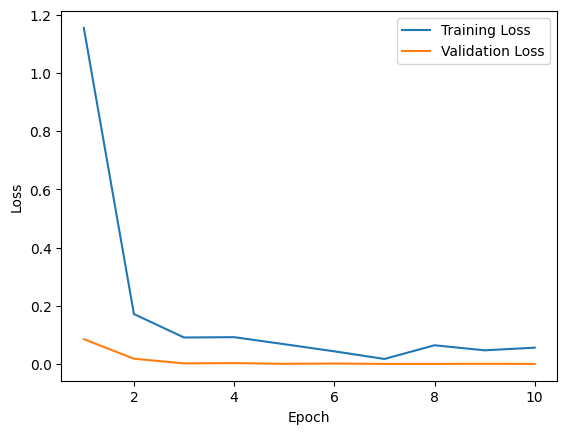

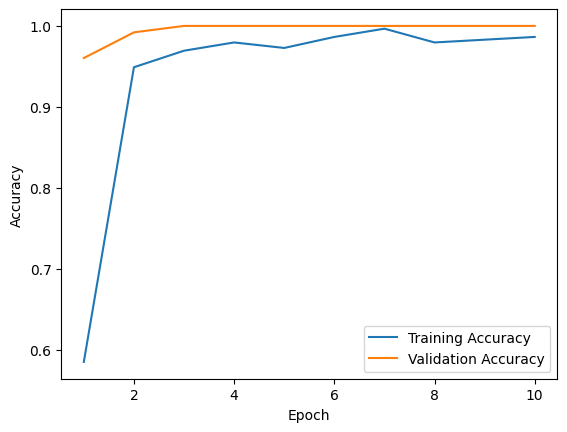

In [ ]:
import matplotlib.pyplot as plt

# Plot kurva loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot kurva akurasi
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Mendefinisikan path untuk menyimpan model
os.makedirs('train_model', exist_ok=True)
model_path = os.path.join('train_model', 'model.pth')

# Menyimpan model
torch.save(vgg.state_dict(), model_path)

In [ ]:
# Load model
vgg = models.vgg16(pretrained=False)
vgg.classifier[-1] = nn.Linear(vgg.classifier[-1].in_features, num_classes)
vgg.load_state_dict(torch.load('/content/train_model/model.pth'))
vgg = vgg.to(device)
vgg.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels_tuple in val_loader:
        inputs = inputs.to(device)

        # Convert labels to numerical labels
        labels = [val_dataset.classes.index(label) for label in labels_tuple]
        labels = torch.tensor(labels).to(device)

        outputs = vgg(inputs)

        # Convert predicted labels to numpy array
        _, val_predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(val_predicted.cpu().numpy())

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        21
           3       1.00      1.00      1.00        21
           4       1.00      1.00      1.00        21
           5       1.00      1.00      1.00        21

    accuracy                           1.00       126
   macro avg       1.00      1.00      1.00       126
weighted avg       1.00      1.00      1.00       126

